# **DS** test assignment from mobile operator

Binary classification problem:
"1" - the subscriber is a driver (belongs to the drivers segment),
"0" - the subscriber is not a driver (does not belong to the drivers segment).

The files tabular_data.csv and hashed_feature.csv ̶ here are descriptive characteristics for 4084 subscribers ("ID" is the subscriber ID).
The train.csv file ̶ is the target label data (the subscriber's belonging to the driver segment).
File test.csv ̶ is the list of subscribers for which we want to make a prediction, by which we will evaluate the quality of the model. The ROC-AUC is used as the metric.

"The file tabular_data.csv contains the numeric data on the activity of subscribers for 12 periods.
- period - period number (periods are consecutive, 1 is the newest)
- id - subscriber ID
- feature_0 - feature_49 - data on the subscriber's activity in the corresponding period.


"File hashed_feature.csv - here is the set of hashed values of one categorical variable for the subscriber.
- id - subscriber's identifier
- feature_50 - hash of the value of the categorical variable.


"File train.csv - here is the data with the target label.
- id - identifier of the target
- target - target label value (1 - belongs to drivers segment, 0 - does not belong to drivers segment).


"test.csv file - list of subscribers for which you want to make predictions with your models.
- id - the subscriber's identifier
- score - the probability that the caller belongs to the drivers segment (class "1"). This probability is determined by your model.


You need to build your model on the subscribers whose target label is contained in the train.csv file. 
To do this, you need to use data from tabular_data.csv and hashed_feature.csv files. 
Then, using your model, you need to fill in the score column for the subscribers from the test.csv file - the probability that the subscriber belongs to the driver segment. 
Note that you need to predict the fact of the relation to the drivers segment, without reference to the period.

**P.S. The target in ROC-AUC is 90%+**

In [85]:
! pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import CatBoostClassifier
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score

In [87]:
tabular_data = pd.read_csv('tabular_data.csv')

In [88]:
train = pd.read_csv('train.csv')

In [89]:
test = pd.read_csv('test.csv')

In [90]:
df = train.merge(tabular_data, on='id').reset_index()

In [91]:
hashed_feature = pd.read_csv('hashed_feature.csv')
hashed_feature.head()

,id,feature_50
0,0,7984b0a0e139cabadb5afc7756d473fb34d23819
1,0,47904b3331202e9881d003ff449c2eabfbc75460
2,0,a99c4b3af723874ddd85af322beea81b64437294
3,0,4dce5381031a88aed6b12ef71b6f7c3148e7b3c8
4,0,d62db721202cb6636887f450a7b77fa97db03b05


In [92]:
hashed_feature["feature_50"].fillna( method ='ffill', inplace = True)
feature_50 = hashed_feature.groupby(['id'], as_index=True).agg({'feature_50': ' '.join})
feature_50['feature_50'].head()

id
0    7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
1    b9bd0ce1fa4ae3e15721b59467b686db6fdf99ed a013c...
2    f037f1a9708bb2438a38d58fb441ac4008b0e831 f037f...
3    3d11305bc7de6663644acf3066ecca90f2e5acb8 10a66...
4    db6e2207646e991c7c196063bdc9377fb416c732 745dd...
Name: feature_50, dtype: object

In [93]:
df = df.merge(feature_50, how='left', on='id')

In [94]:
df

,index,id,target,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50
0,0,0,0,1,110.0,55.00,0.432017,0.000000,176.78,0.000000,...,0,0.000000,0.0,55.00,2.0,0.526552,145.0,133.28,0.0,7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
1,1,0,0,2,110.0,110.00,0.397517,0.000000,315.42,0.000000,...,0,0.000000,0.0,110.00,1.0,0.481063,130.0,229.97,0.0,7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
2,2,0,0,3,110.0,55.00,0.359440,0.000000,354.55,0.000000,...,0,0.000000,0.0,55.00,1.0,0.509598,180.0,231.78,0.0,7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
3,3,0,0,4,110.0,55.00,0.285707,0.000000,229.98,0.000000,...,0,0.000000,0.0,55.00,0.0,0.680089,142.0,183.83,0.0,7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
4,4,0,0,5,110.0,55.00,0.101487,444.730391,307.12,0.000000,...,0,20.014485,0.0,55.00,0.0,0.776175,85.0,155.83,0.0,7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49003,49003,4083,0,8,110.0,326.97,0.075341,51748.802468,183.98,51853.985279,...,0,10.277948,1.0,316.17,7.0,0.836954,107.0,149.05,8.0,59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
49004,49004,4083,0,9,110.0,158.04,0.177228,55868.890064,67.27,55621.921670,...,0,55.430980,0.0,157.72,23.0,-0.845186,93.0,47.87,9.0,59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
49005,49005,4083,0,10,110.0,31.76,0.108558,61571.657643,65.63,61210.237966,...,0,13.208262,1.0,19.80,4.0,0.627217,71.0,60.85,2.0,59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
49006,49006,4083,0,11,110.0,319.11,0.111005,44667.081471,160.37,44061.415943,...,0,6.807361,0.0,317.19,1.0,0.678899,122.0,129.02,0.0,59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...


In [95]:
df['feature_50']

0        7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
1        7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
2        7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
3        7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
4        7984b0a0e139cabadb5afc7756d473fb34d23819 47904...
                               ...                        
49003    59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
49004    59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
49005    59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
49006    59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
49007    59b7b0f7a586908eec25f56656202691329b5cd8 8ff89...
Name: feature_50, Length: 49008, dtype: object

In [96]:
df["feature_25"].fillna( method ='ffill', inplace = True)

In [97]:
X = df.drop(columns=['target'], axis=0).copy()

In [98]:
Y = df['target']

In [99]:
from sklearn.preprocessing import StandardScaler

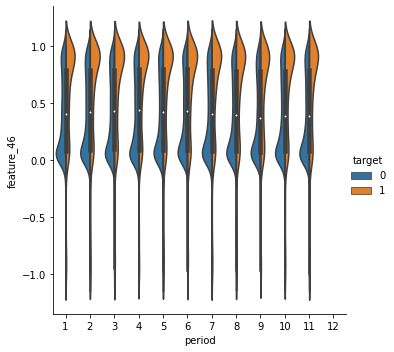

In [100]:
sns.catplot(
    data=df, x="period", y="feature_46", hue="target",
    kind="violin", split=True,
)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [102]:
text_feature = ['feature_50']
cat_feature = ['feature_25']

In [103]:
model = CatBoostClassifier(verbose=100, eval_metric='AUC', text_features=text_feature, cat_features=cat_feature)

In [104]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.075883
0:	test: 0.6981313	best: 0.6981313 (0)	total: 380ms	remaining: 6m 20s
100:	test: 0.8291061	best: 0.8291061 (100)	total: 36s	remaining: 5m 20s
200:	test: 0.9004578	best: 0.9004578 (200)	total: 1m 10s	remaining: 4m 39s
300:	test: 0.9457250	best: 0.9457250 (300)	total: 1m 46s	remaining: 4m 6s
400:	test: 0.9705691	best: 0.9705691 (400)	total: 2m 21s	remaining: 3m 30s
500:	test: 0.9833346	best: 0.9833346 (500)	total: 2m 55s	remaining: 2m 55s
600:	test: 0.9890637	best: 0.9890637 (600)	total: 3m 30s	remaining: 2m 19s
700:	test: 0.9926474	best: 0.9926474 (700)	total: 4m 5s	remaining: 1m 44s
800:	test: 0.9946919	best: 0.9946919 (800)	total: 4m 40s	remaining: 1m 9s
900:	test: 0.9965731	best: 0.9965736 (899)	total: 5m 15s	remaining: 34.7s
999:	test: 0.9975364	best: 0.9975364 (999)	total: 5m 50s	remaining: 0us

bestTest = 0.9975363503
bestIteration = 999

